In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import contextily as cx
import datetime as dt
import json
from joblib import Parallel, delayed

from functions_file import *
print(testfunction(4))

from matplotlib.collections import LineCollection
import matplotlib.colors as mcol

16


## Filter for bus/heavy/medium
First, filter the Polygon-data for the aforementioned. Then see, how often they went to zero

In [2]:
polygons = pd.read_csv('../data/polygons11.csv')
polygons = polygons.drop([4])
polygon_names = polygons.name.values

In [7]:
polygon_name = polygon_names[5]
print(polygon_name)
waypoints_w_dist_mode,POLYGON = load_data(polygon_name,polygons)

polygon_r6


<AxesSubplot:>

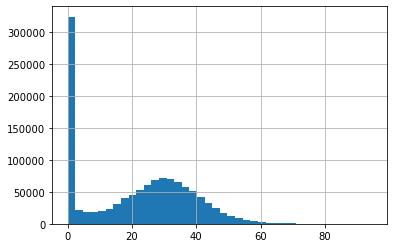

In [8]:
waypoints_w_dist_mode.speed.hist(bins=40)

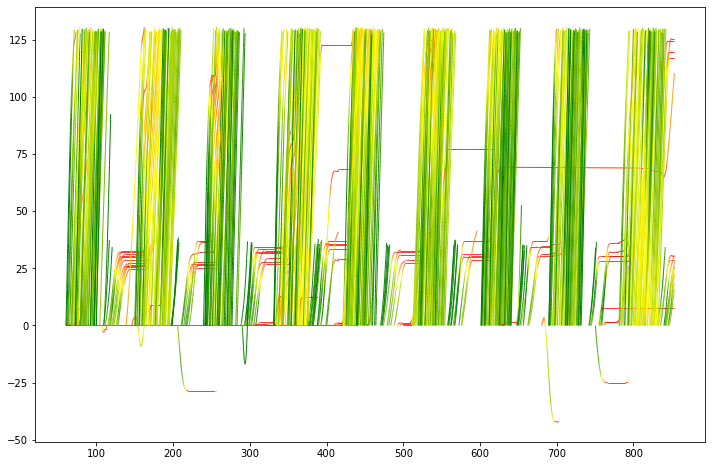

In [12]:
plot_line_trajectories(waypoints_w_dist_mode[waypoints_w_dist_mode.exp_id==12],'all',grid='off') #all startinb by 0, no link(exp_id filtering)

In [17]:
waypoints_w_dist_bus = waypoints_w_dist_mode[waypoints_w_dist_mode['type']=='Bus']
all_list = []
for val in ['time','speed','trv_dist']:
    all_list.append(waypoints_w_dist_bus.groupby('unique_id')[val].apply(list))

In [6]:
time_speed_trvdist = list(zip(all_list[0],all_list[1],all_list[2]))

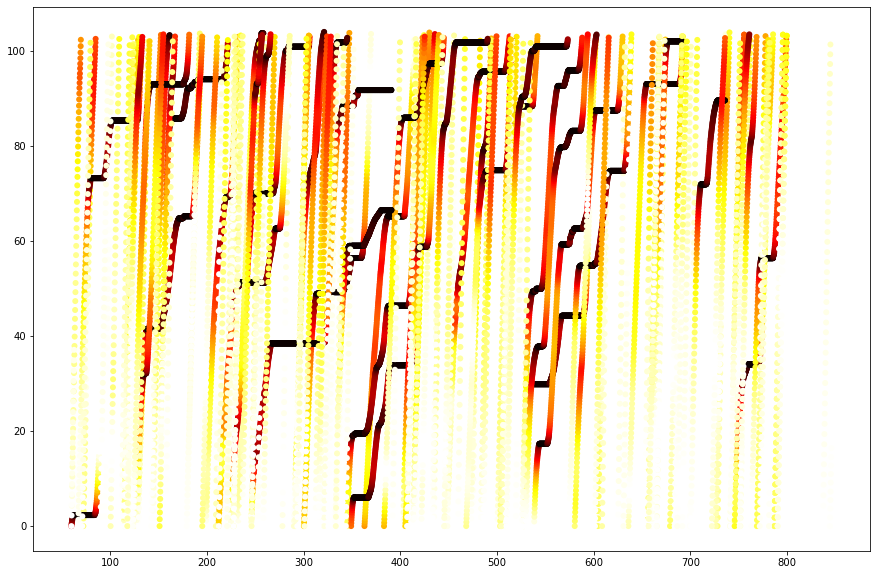

In [36]:
from matplotlib import cm
plt.figure(figsize=(15,10))
for x_y in time_speed_trvdist:
    plt.scatter(x_y[0],[x-x_y[2][0] for x in x_y[2]],c=cm.hot(np.abs([x/max(x_y[1]) for x in x_y[1]])), edgecolor='none')#, linewidth=2, cmap='autumn')

### 1. Reformat MS and LD data

**Key settings for reformatting**

In [3]:
polygons = pd.read_csv('../data/polygons11.csv')
polygons = polygons.drop([4])
polygons['polygon'] = polygons.name
poly_cols = ['polygon','lanes','direction','busstops','seplane','length','complexity','road_rank']

savefactors = {}
scalefactorsfile = 'scalefactors_bypolygon.pkl' # 'scalefactors_bypolygon_bymode.pkl'

# LD and MS data should have same resampling
resample = '5s' #30s
window = '5s' # 3min #3T
polygon_names = polygons.name.values

In [8]:
polygon_name = polygon_names[0]
POLYGON = get_polygon(polygon_name,polygons)
nonresampled = import_sensor_data(POLYGON['name'],'MS')
#mode = 'Car'
#moede_sel = nonresampled[nonresampled['mode']==mode]
#exp_sec = moede_sel[moede_sel['exp_id']==1]
nonresampled.iloc[0]

polygon                                             polygon_r0
mode                                                       Car
day                                            [1, 2, 3, 4, 5]
DOW                                                        Wed
exp_id                                                       1
speeds       [43.562996752112625, 45.05219943695104, 22.970...
densities    [31.632183908045974, 41.53791887125222, 17.299...
flows        [1377.992724848436, 1871.3746051835471, 397.38...
times        [[[2018-10-24 08:31:13, 2018-10-24 08:31:43, 2...
Name: 0, dtype: object

**Mobile sensor data**

In [4]:
#################
# Resample, scale and gather data for mobile sensor modes
#################
save = 'on'

for polygon_name in polygon_names:
    
    POLYGON = get_polygon(polygon_name,polygons)
    # 1. load 'regular' and 'car' data
    # 1.a. file 1 - regular
    nonresampled = import_sensor_data_with_parked(POLYGON['name'],'MS',resample_interval = '5s') #switch back
    modes        = set(nonresampled['mode'])
    resampled    = sensor_resample_window(nonresampled,modes,resample=resample,window=window,POLYGON=POLYGON,plot='off',filna=False)
    display(nonresampled[nonresampled['mode']=='all'].head())
    display(resampled[resampled['mode']=='all'].head())
    # 1.b. file 2 - car penetration rates
    nonresampled_cars = import_sensor_data(POLYGON['name'],'MS',cars='Yes')
    modes_cars        = set(nonresampled_cars['mode'])
    resampled_cars    = sensor_resample_window(nonresampled_cars,modes_cars,resample=resample,window=window,POLYGON=POLYGON,plot='off',filna=False)
    # 1.c. combine data
    data = pd.concat([resampled,resampled_cars])
    
    # 2. normalize/scale by link
    cols       = ['densities','flows']
    xx         = data[data['mode']=='all'][cols]
    means      = xx.mean()
    data[cols] = data[cols]/xx.mean() 
    interval   = data[(data['mode']=='all')&(data.densities>0.2)&(data.densities<2)]
    slope      = interval.flows.mean()/interval.densities.mean()
    data.flows = data.flows/slope
    savefactors[polygon_name+'_MS'] = [1,slope,means[0],means[1]]
    
    # 3. reformat - create a df per mode, rename columns, merge
    result = []
    for mode in set(data['mode']):
        # can exclude exp_id - not needed & issues due to diff. experiment start/end times
        tmp = data[data['mode']==mode][['exp_id','polygon','DOW','times','speeds','densities','flows']]
        tmp = tmp.rename(columns={'speeds':'v_%s'%(mode),'densities':'k_%s'%(mode),'flows':'q_%s'%(mode)})
        if (len(result)<1):
            result = tmp
        else:
            result = pd.merge(result, tmp, on=['polygon','DOW','times','exp_id'],how='outer')
    
    # 4. add polygon information
    result = pd.merge(result, polygons[poly_cols], how='outer', on=['polygon'])
    display(result.head(2))
    
    # 5. save
    if save=='on':
        result.to_pickle('../output/data_processed_with_parked_5s/processed_data_MS_%s.pkl'%(POLYGON['name']))##change here
    print('Saved %s.'%(polygon_name))
    print('Length:',len(result))


610 610 610 610
487 487 487 487
634 634 634 634
577 577 577 577
601 601 601 601
422 422 422 422
532 532 532 532
521 521 521 521
622 622 622 622
504 504 504 504
678 678 678 678
589 589 589 589
614 614 614 614
487 487 487 487
649 649 649 649
564 564 564 564
617 617 617 617
501 501 501 501
669 669 669 669
580 580 580 580
485 485 485 485
384 384 384 384
422 422 422 422
436 436 436 436
514 514 514 514
426 426 426 426
589 589 589 589
480 480 480 480


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
108,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1,"[40.330777880041325, 40.10872139705457, 26.752...","[34.2857142857143, 89.52380952380945, 84.19047...","[1382.769527315703, 3590.685534593454, 2252.31...","[[[2018-10-24 08:31:08, 2018-10-24 08:31:13, 2..."
109,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,2,"[51.639004426016086, 46.11452295616603, 35.541...","[57.904761904761855, 51.80952380952379, 23.619...","[2990.144256287405, 2389.171475062315, 839.463...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
110,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,3,"[5.86124812662806, 4.9624130437535, 3.88404205...","[368.7619047619047, 390.0952380952376, 406.857...","[2161.405023457509, 1935.8136978299344, 1580.2...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
111,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,4,"[2.885972826162372, 2.1427544122557185, 1.2583...","[431.23809523809484, 494.47619047619077, 510.0...","[1244.5414244631627, 1059.5410388982568, 641.8...","[[[2018-10-24 10:01:31, 2018-10-24 10:01:36, 2..."
112,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,5,"[20.076752947553647, 15.395226306421938, 9.065...","[223.2380952380953, 247.23809523809507, 258.66...","[4481.896086577692, 3806.2864277591734, 2344.8...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11715,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,40.330778,34.285714,1382.769527,2018-10-24 08:31:05
11716,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,40.108721,89.523810,3590.685535,2018-10-24 08:31:10
11717,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,26.752656,84.190476,2252.318857,2018-10-24 08:31:15
11718,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,36.919118,80.000000,2953.529411,2018-10-24 08:31:20
11719,polygon_r0,all,"[1, 2, 3, 4, 5]",Wed,1.0,51.747807,91.809524,4750.941509,2018-10-24 08:31:25


93 93 93 93
73 73 73 73
105 105 105 105
91 91 91 91


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_Medium Vehicle,k_Medium Vehicle,q_Medium Vehicle,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r0,Wed,2018-10-24 08:31:35,45.449044,0.057659,0.084569,NaN,0.0,0.0,...,44.171422,0.09134,0.130205,3,170,0,1,0.105,1,0
1,NaN,polygon_r0,Wed,2018-10-24 08:31:40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,170,0,1,0.105,1,0


Saved polygon_r0.
Length: 8027
517 517 517 517
444 444 444 444
608 608 608 608
568 568 568 568
632 632 632 632
497 497 497 497
688 688 688 688
619 619 619 619
649 649 649 649
541 541 541 541
704 704 704 704
628 628 628 628
638 638 638 638
514 514 514 514
696 696 696 696
615 615 615 615
642 642 642 642
519 519 519 519
686 686 686 686
626 626 626 626
241 241 241 241
165 165 165 165
157 157 157 157
87 87 87 87
616 616 616 616
473 473 473 473
690 690 690 690
550 550 550 550


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
108,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1,"[30.29266746352435, 32.15101566229321, 33.6968...","[198.85714285714286, 189.3333333333332, 180.57...","[6023.913301317985, 6087.258965394178, 6084.68...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
109,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,2,"[0.29733838443368865, 20.234549918027945, 29.8...","[48.7619047619047, 124.95238095238092, 214.476...","[14.498785983814134, 2528.3551897573957, 6393....","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
110,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,3,"[24.885039870620574, 23.506945490505352, 21.32...","[202.66666666666669, 182.8571428571427, 148.57...","[5043.36808044577, 4298.412889692403, 3167.878...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
111,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,4,"[0.0, 0.0, 4.160387916975085, 25.6566065875938...","[46.47619047619043, 45.714285714285694, 51.809...","[0.0, 0.0, 215.54771684137577, 3284.0456432120...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:05, 2..."
112,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,5,"[37.835162679448004, 38.65417241424942, 36.129...","[194.66666666666646, 215.99999999999983, 194.2...","[7365.2450015992035, 8349.30124147787, 7019.41...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11720,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,30.292667,198.857143,6023.913301,2018-10-24 08:31:00
11721,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,32.151016,189.333333,6087.258965,2018-10-24 08:31:05
11722,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,33.696823,180.571429,6084.683550,2018-10-24 08:31:10
11723,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,29.834377,120.000000,3580.125282,2018-10-24 08:31:15
11724,polygon_r1,all,"[1, 2, 3, 4, 5]",Wed,1.0,21.071699,38.857143,818.786014,2018-10-24 08:31:20


89 89 89 89
78 78 78 78
107 107 107 107
86 86 86 86


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_all,k_all,q_all,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r1,Wed,2018-10-24 08:32:00,33.854055,0.079896,0.126464,35.03004,0.635927,1.041544,...,0.081804,0.085169,0.000326,3,255,2,0,0.105,1,0
1,NaN,polygon_r1,Wed,2018-10-24 08:32:05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,255,2,0,0.105,1,0


Saved polygon_r1.
Length: 8187
622 622 622 622
521 521 521 521
659 659 659 659
566 566 566 566
582 582 582 582
460 460 460 460
658 658 658 658
537 537 537 537
650 650 650 650
541 541 541 541
704 704 704 704
618 618 618 618
635 635 635 635
501 501 501 501
654 654 654 654
428 428 428 428
650 650 650 650
541 541 541 541
704 704 704 704
618 618 618 618
479 479 479 479
385 385 385 385
493 493 493 493
153 153 153 153
464 464 464 464
180 180 180 180
438 438 438 438
268 268 268 268


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
105,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1,"[18.918661741454883, 26.346583021982305, 30.58...","[84.28571428571418, 131.42857142857136, 120.95...","[1594.572918208338, 3462.6937686033866, 3698.9...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
106,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,2,"[0.0, 0.0, 0.0, 0.0, 0.0055689858587909796, 0....","[132.85714285714266, 128.5714285714285, 128.57...","[0.0, 0.0, 0.0, 0.0, 0.7398795498108005, 28.03...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
107,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,3,"[8.742383112654894, 12.411067166288626, 13.489...","[237.142857142857, 249.04761904761878, 236.666...","[2073.1937095724447, 3090.946727604259, 3192.6...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
108,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,4,"[0.05813524048102519, 4.305119221279574, 10.08...","[279.5238095238092, 293.33333333333314, 299.52...","[16.250183886838926, 1262.834971575341, 3021.3...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:05, 2..."
109,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,5,"[29.88745137777942, 34.259288135999384, 17.022...","[26.66666666666662, 36.6666666666666, 42.85714...","[796.9987034074499, 1256.1738983199753, 729.54...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11729,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,18.918662,84.285714,1594.572918,2018-10-24 08:31:00
11730,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,26.346583,131.428571,3462.693769,2018-10-24 08:31:05
11731,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,30.581774,120.952381,3698.938335,2018-10-24 08:31:10
11732,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,34.246432,106.190476,3636.644871,2018-10-24 08:31:15
11733,polygon_r2,all,"[1, 2, 3, 4, 5]",Wed,1.0,39.207598,124.285714,4872.944357,2018-10-24 08:31:20


93 93 93 93
76 76 76 76
99 99 99 99
97 97 97 97


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_Medium Vehicle,k_Medium Vehicle,q_Medium Vehicle,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r2,Wed,2018-10-24 08:31:25,8.662498,0.083264,0.08228,NaN,0.0,0.0,...,NaN,0.0,0.0,2,35,0,0,0.084,1,0
1,NaN,polygon_r2,Wed,2018-10-24 08:31:30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,35,0,0,0.084,1,0


Saved polygon_r2.
Length: 8172
635 635 635 635
494 494 494 494
728 728 728 728
604 604 604 604
605 605 605 605
467 467 467 467
685 685 685 685
540 540 540 540
651 651 651 651
509 509 509 509
743 743 743 743
623 623 623 623
630 630 630 630
492 492 492 492
714 714 714 714
593 593 593 593
636 636 636 636
495 495 495 495
731 731 731 731
609 609 609 609
151 151 151 151
393 393 393 393
175 175 175 175
339 339 339 339
589 589 589 589
414 414 414 414
607 607 607 607
532 532 532 532


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
107,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1,"[50.29392128701415, 16.44396090152443, 19.0017...","[31.555555555555536, 19.555555555555536, 13.77...","[1587.0526272791121, 321.5707909631441, 261.80...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
108,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,2,"[27.824537780758302, 26.885737590288816, 31.20...","[212.88888888888863, 177.7777777777777, 188.88...","[5923.534931992538, 4779.686682718009, 5894.52...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
109,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,3,"[29.21414089780563, 11.111360378232922, 11.715...","[51.11111111111108, 44.000000000000014, 71.111...","[1493.167201443398, 488.8998566422487, 833.087...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
110,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,4,"[9.690193425539146, 8.77538674129889, 4.046282...","[85.33333333333324, 96.88888888888884, 106.666...","[826.8965056460062, 850.2374709347365, 431.603...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:05, 2..."
111,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,5,"[27.116547082047255, 24.141976843358446, 21.80...","[242.22222222222214, 223.9999999999999, 212.88...","[6568.230293207, 5407.8028129122895, 4642.4205...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11637,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,50.293921,31.555556,1587.052627,2018-10-24 08:31:00
11638,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,16.443961,19.555556,321.570791,2018-10-24 08:31:05
11639,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,19.001704,13.777778,261.801253,2018-10-24 08:31:10
11640,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,10.493005,12.000000,125.916055,2018-10-24 08:31:15
11641,polygon_r3,all,"[1, 2, 3, 4, 5]",Wed,1.0,15.693565,14.814815,232.497264,2018-10-24 08:31:20


97 97 97 97
61 61 61 61
111 111 111 111
85 85 85 85


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_Medium Vehicle,k_Medium Vehicle,q_Medium Vehicle,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r3,Wed,2018-10-24 08:31:50,27.169282,0.118287,0.116171,31.054758,0.133681,0.150065,...,28.162837,0.147049,0.149699,3,310,0,1,0.09,1,0
1,NaN,polygon_r3,Wed,2018-10-24 08:31:55,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,310,0,1,0.09,1,0


Saved polygon_r3.
Length: 8125
620 620 620 620
486 486 486 486
652 652 652 652
596 596 596 596
601 601 601 601
442 442 442 442
591 591 591 591
522 522 522 522
630 630 630 630
500 500 500 500
683 683 683 683
623 623 623 623
604 604 604 604
471 471 471 471
655 655 655 655
590 590 590 590
628 628 628 628
484 484 484 484
678 678 678 678
620 620 620 620
514 514 514 514
410 410 410 410
478 478 478 478
489 489 489 489
565 565 565 565
412 412 412 412
522 522 522 522
534 534 534 534


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
108,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1,"[27.979066678178654, 24.83397698001749, 21.087...","[19.733333333333317, 37.33333333333325, 49.066...","[552.1202491160583, 927.1351405873176, 1034.66...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
109,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,2,"[5.021335460381702, 2.6133019960342785, 2.2126...","[446.9333333333333, 481.06666666666626, 489.06...","[2244.2021950932617, 1257.1724802255558, 1082....","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
110,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,3,"[8.681947984677057, 7.546637042542973, 3.97933...","[295.9999999999998, 231.46666666666647, 172.79...","[2569.856603464407, 1746.794920780612, 687.628...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
111,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,4,"[11.952907939483993, 17.224281255565522, 18.52...","[427.2000000000003, 318.39999999999964, 271.46...","[5106.282271747565, 5484.211151772056, 5030.20...","[[[2018-10-24 10:01:31, 2018-10-24 10:01:36, 2..."
112,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,5,"[6.370849062734447, 11.565279407833332, 19.113...","[558.9333333333328, 482.1333333333329, 366.399...","[3560.8799027977034, 5576.006711830039, 7003.3...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11701,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,27.979067,19.733333,552.120249,2018-10-24 08:31:00
11702,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,24.833977,37.333333,927.135141,2018-10-24 08:31:05
11703,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,21.087017,49.066667,1034.669645,2018-10-24 08:31:10
11704,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,1.0,12.659319,23.466667,297.072026,2018-10-24 08:31:15
11705,polygon_r5,all,"[1, 2, 3, 4, 5]",Wed,NaN,NaN,NaN,NaN,2018-10-24 08:31:20


92 92 92 92
76 76 76 76
94 94 94 94
91 91 91 91


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_Medium Vehicle,k_Medium Vehicle,q_Medium Vehicle,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r5,Wed,2018-10-24 08:32:10,34.3886,0.084854,0.152106,NaN,0.0,0.0,...,34.922537,0.090915,0.165501,3,170,0,1,0.075,1,0
1,NaN,polygon_r5,Wed,2018-10-24 08:32:15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,170,0,1,0.075,1,0


Saved polygon_r5.
Length: 8027
641 641 641 641
537 537 537 537
703 703 703 703
630 630 630 630
542 542 542 542
474 474 474 474
578 578 578 578
563 563 563 563
644 644 644 644
541 541 541 541
704 704 704 704
630 630 630 630
632 632 632 632
529 529 529 529
693 693 693 693
619 619 619 619
643 643 643 643
535 535 535 535
702 702 702 702
627 627 627 627
113 113 113 113
184 184 184 184
330 330 330 330
29 29 29 29
579 579 579 579
468 468 468 468
652 652 652 652
549 549 549 549


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
105,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1,"[38.71770152560754, 24.0223021157083, 12.42234...","[39.233716475095754, 59.46360153256704, 90.114...","[1519.0393242230684, 1428.4526009034205, 1119....","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
106,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,2,"[41.73576044453812, 38.55554284253672, 42.6404...","[135.7854406130268, 135.78544061302668, 124.13...","[5667.108621281344, 5235.281372948275, 5293.29...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
107,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,3,"[32.029608735646455, 23.952013324480884, 12.50...","[59.77011494252865, 105.44061302681986, 112.79...","[1914.4133956938083, 2525.514968159822, 1410.3...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
108,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,4,"[48.58503782649056, 44.953701716751254, 41.331...","[113.10344827586212, 80.30651340996162, 49.348...","[5495.13531278928, 3610.0750497436993, 2039.64...","[[[2018-10-24 10:01:31, 2018-10-24 10:01:36, 2..."
109,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,5,"[43.66431775174357, 45.87646752187335, 47.6569...","[77.85440613026823, 81.5325670498084, 87.35632...","[3399.459527645324, 3740.426164235497, 4163.13...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11704,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,38.717702,39.233716,1519.039324,2018-10-24 08:31:00
11705,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,24.022302,59.463602,1428.452601,2018-10-24 08:31:05
11706,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,12.422346,90.114943,1119.438986,2018-10-24 08:31:10
11707,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,4.660067,101.149425,471.363051,2018-10-24 08:31:15
11708,polygon_r6,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.956191,107.892720,103.166012,2018-10-24 08:31:20


80 80 80 80
70 70 70 70
102 102 102 102
91 91 91 91


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_Medium Vehicle,k_Medium Vehicle,q_Medium Vehicle,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r6,Wed,2018-10-24 08:33:50,13.729322,0.059664,0.044111,NaN,0.0,0.0,...,NaN,0.0,0.0,3,260,0,1,0.1305,1,0
1,NaN,polygon_r6,Wed,2018-10-24 08:33:55,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,260,0,1,0.1305,1,0


Saved polygon_r6.
Length: 8126
549 549 549 549
495 495 495 495
653 653 653 653
578 578 578 578
334 334 334 334
314 314 314 314
536 536 536 536
450 450 450 450
592 592 592 592
530 530 530 530
688 688 688 688
611 611 611 611
554 554 554 554
519 519 519 519
635 635 635 635
549 549 549 549
586 586 586 586
524 524 524 524
681 681 681 681
602 602 602 602
375 375 375 375
276 276 276 276
492 492 492 492
55 55 55 55
301 301 301 301
105 105 105 105
144 144 144 144
166 166 166 166


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
103,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1,"[0.0, 0.0, 0.0, 0.342933094245483, 8.014480059...","[25.684210526315788, 25.26315789473683, 25.263...","[0.0, 0.0, 0.0, 8.95235867082944, 310.45564860...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
104,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,2,"[31.986660608672945, 29.255078351073102, 25.10...","[55.57894736842109, 38.73684210526316, 36.6315...","[1777.7849264609818, 1133.2493508626212, 919.7...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
105,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,3,"[0.1698197796395975, 0.0, 0.0, 3.6642938853557...","[63.15789473684207, 63.15789473684207, 65.2631...","[10.725459766711413, 0.0, 0.0, 277.71490499538...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
106,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,4,"[5.665723000396585, 4.64670914504174, 2.885896...","[103.57894736842096, 101.05263157894731, 101.4...","[586.8496244621299, 469.5621872884282, 292.842...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:05, 2..."
107,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,5,"[0.0, 0.463662353267373, 4.5743905233848, 4.18...","[116.2105263157894, 116.2105263157894, 140.210...","[0.0, 53.88244610601889, 641.377702857742, 630...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11579,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.000000,25.684211,0.000000,2018-10-24 08:31:00
11580,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.000000,25.263158,0.000000,2018-10-24 08:31:05
11581,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.000000,25.263158,0.000000,2018-10-24 08:31:10
11582,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.342933,26.105263,8.952359,2018-10-24 08:31:15
11583,polygon_r7,all,"[1, 2, 3, 4, 5]",Wed,1.0,8.014480,38.736842,310.455649,2018-10-24 08:31:20


45 45 45 45
40 40 40 40
70 70 70 70
59 59 59 59


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_Medium Vehicle,k_Medium Vehicle,q_Medium Vehicle,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r7,Wed,2018-10-24 08:33:00,26.931174,0.134656,0.498277,NaN,NaN,NaN,...,NaN,NaN,NaN,2,220,0,0,0.095,1,0
1,NaN,polygon_r7,Wed,2018-10-24 08:33:05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,220,0,0,0.095,1,0


Saved polygon_r7.
Length: 8097
635 635 635 635
492 492 492 492
718 718 718 718
564 564 564 564
599 599 599 599
464 464 464 464
689 689 689 689
504 504 504 504
653 653 653 653
506 506 506 506
743 743 743 743
585 585 585 585
625 625 625 625
484 484 484 484
709 709 709 709
552 552 552 552
641 641 641 641
492 492 492 492
732 732 732 732
574 574 574 574
389 389 389 389
383 383 383 383
473 473 473 473
359 359 359 359
583 583 583 583
423 423 423 423
666 666 666 666
487 487 487 487


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
107,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1,"[31.129558418263922, 24.335682763267943, 22.68...","[64.81012658227839, 48.607594936708864, 34.936...","[2017.5106215381145, 1182.899010265176, 792.43...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
108,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,2,"[39.702746362850114, 41.556730790393544, 41.44...","[142.2784810126581, 131.139240506329, 75.44303...","[5648.84644453715, 5449.718113778187, 3126.478...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
109,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,3,"[20.29052901596824, 11.765171166147722, 7.8003...","[138.73417721518973, 113.41772151898726, 88.10...","[2814.989848291287, 1334.378906945361, 687.222...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
110,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,4,"[25.222432150435747, 24.10805064565268, 15.805...","[109.87341772151889, 133.16455696202522, 111.3...","[2771.274823617495, 3210.3378834464047, 1760.6...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:05, 2..."
111,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,5,"[29.309295832090363, 34.21939274945827, 36.639...","[112.40506329113911, 128.60759493670872, 208.1...","[3294.513253024837, 4400.873801702477, 7624.65...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11656,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,31.129558,64.810127,2017.510622,2018-10-24 08:31:00
11657,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,24.335683,48.607595,1182.899010,2018-10-24 08:31:05
11658,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,22.682134,34.936709,792.439115,2018-10-24 08:31:10
11659,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,24.297022,30.379747,738.137368,2018-10-24 08:31:15
11660,polygon_r8,all,"[1, 2, 3, 4, 5]",Wed,1.0,32.155437,84.556962,2718.966041,2018-10-24 08:31:20


89 89 89 89
74 74 74 74
109 109 109 109
85 85 85 85


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_Medium Vehicle,k_Medium Vehicle,q_Medium Vehicle,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r8,Wed,2018-10-24 08:31:40,23.551355,0.127005,0.105768,29.348246,0.261545,0.271421,...,NaN,NaN,NaN,3,310,1,0,0.079,1,0
1,NaN,polygon_r8,Wed,2018-10-24 08:31:45,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,310,1,0,0.079,1,0


Saved polygon_r8.
Length: 8034
543 543 543 543
466 466 466 466
657 657 657 657
525 525 525 525
627 627 627 627
497 497 497 497
677 677 677 677
604 604 604 604
642 642 642 642
539 539 539 539
704 704 704 704
629 629 629 629
637 637 637 637
516 516 516 516
684 684 684 684
599 599 599 599
640 640 640 640
535 535 535 535
702 702 702 702
628 628 628 628
421 421 421 421
233 233 233 233
463 463 463 463
324 324 324 324
459 459 459 459
355 355 355 355
630 630 630 630
484 484 484 484


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
106,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1,"[0.7992912088349712, 5.55258379010316, 10.2776...","[282.5806451612901, 282.1505376344084, 261.935...","[225.8642254643336, 1566.6645016377076, 2692.0...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
107,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,2,"[1.5965933514549424, 1.6106213736615542, 1.565...","[344.94623655913944, 388.8172043010752, 416.77...","[550.7388678997258, 626.237299694643, 652.6110...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
108,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,3,"[0.6152009965930902, 3.314983794947742, 9.2934...","[219.784946236559, 175.91397849462354, 190.537...","[135.21191796088985, 583.1519880144626, 1770.7...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
109,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,4,"[1.7699376227412318, 1.3400630762472379, 0.548...","[194.83870967741936, 206.4516129032257, 207.31...","[344.85236262442066, 276.6581834833006, 113.75...","[[[2018-10-24 10:01:31, 2018-10-24 10:01:36, 2..."
110,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,5,"[7.25779815273108, 3.0188863962197434, 0.93770...","[203.01075268817198, 207.3118279569891, 219.78...","[1473.4110658447607, 625.8508571948023, 206.09...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11727,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.799291,282.580645,225.864225,2018-10-24 08:31:00
11728,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,5.552584,282.150538,1566.664502,2018-10-24 08:31:05
11729,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,10.277671,261.935484,2692.086852,2018-10-24 08:31:10
11730,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,15.713754,224.086022,3521.232577,2018-10-24 08:31:15
11731,polygon_r9,all,"[1, 2, 3, 4, 5]",Wed,1.0,16.967139,163.440860,2773.123724,2018-10-24 08:31:20


71 71 71 71
51 51 51 51
86 86 86 86
67 67 67 67


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_all,k_all,q_all,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r9,Wed,2018-10-24 08:34:35,8.77628,0.078154,0.093818,1.819925,0.309627,0.077075,...,NaN,NaN,NaN,2,350,1,0,0.093,1,1
1,NaN,polygon_r9,Wed,2018-10-24 08:34:40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,350,1,0,0.093,1,1


Saved polygon_r9.
Length: 8050
554 554 554 554
438 438 438 438
672 672 672 672
569 569 569 569
624 624 624 624
492 492 492 492
662 662 662 662
604 604 604 604
641 641 641 641
538 538 538 538
702 702 702 702
630 630 630 630
602 602 602 602
519 519 519 519
688 688 688 688
620 620 620 620
639 639 639 639
538 538 538 538
700 700 700 700
630 630 630 630
487 487 487 487
432 432 432 432
625 625 625 625
439 439 439 439
152 152 152 152
174 174 174 174
210 210 210 210
246 246 246 246


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
106,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1,"[3.0052499778898705, 1.4146494210594707, 1.607...","[405.2173913043477, 443.0434782608695, 417.826...","[1217.779556257982, 626.7512000259132, 671.790...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
107,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,2,"[4.8740519751108256, 8.387160639197463, nan, 6...","[26.52173913043478, 22.608695652173896, 0, 16....","[129.26833499206973, 189.62276227750772, 0, 10...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
108,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,3,"[14.196901160537356, 12.18204415353926, 14.586...","[209.5652173913042, 202.6086956521738, 145.652...","[2975.17667799087, 2468.188076325779, 2124.498...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
109,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,4,"[16.891974171593063, 12.403341563586027, 7.861...","[67.39130434782608, 78.69565217391299, 96.9565...","[1138.3721724334455, 976.0890534822041, 762.20...","[[[2018-10-24 10:01:31, 2018-10-24 10:01:36, 2..."
110,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,5,"[8.855572078948214, 4.399497384652974, 1.30665...","[125.21739130434776, 84.7826086956521, 90.4347...","[1108.871634233515, 373.00086522057785, 118.16...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11743,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,3.005250,405.217391,1217.779556,2018-10-24 08:31:00
11744,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,1.414649,443.043478,626.751200,2018-10-24 08:31:05
11745,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,1.607822,417.826087,671.790066,2018-10-24 08:31:10
11746,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,3.326143,358.695652,1193.072992,2018-10-24 08:31:15
11747,polygon_r10,all,"[1, 2, 3, 4, 5]",Wed,1.0,4.182749,304.782609,1274.829077,2018-10-24 08:31:20


87 87 87 87
73 73 73 73
89 89 89 89
91 91 91 91


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_all,k_all,q_all,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r10,Wed,2018-10-24 08:31:00,4.160699,0.06263,0.034206,3.00525,2.275223,0.897548,...,NaN,NaN,NaN,2,170,1,0,0.092,1,1
1,NaN,polygon_r10,Wed,2018-10-24 08:31:05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,170,1,0,0.092,1,1


Saved polygon_r10.
Length: 8186
599 599 599 599
489 489 489 489
700 700 700 700
454 454 454 454
640 640 640 640
503 503 503 503
740 740 740 740
613 613 613 613
652 652 652 652
509 509 509 509
743 743 743 743
622 622 622 622
645 645 645 645
509 509 509 509
742 742 742 742
620 620 620 620
652 652 652 652
508 508 508 508
740 740 740 740
618 618 618 618
402 402 402 402
213 213 213 213
89 89 89 89
449 449 449 449
625 625 625 625
493 493 493 493
735 735 735 735
589 589 589 589


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
108,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1,"[2.2885605876574435, 0.42364169796770423, 0.26...","[160.33057851239673, 160.99173553718995, 158.6...","[366.9262429797885, 68.20281220174274, 42.2174...","[[[2018-10-24 08:31:00, 2018-10-24 08:31:05, 2..."
109,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,2,"[18.644107773158964, 22.62189966241412, 27.892...","[243.30578512396661, 239.99999999999986, 231.7...","[4536.219279684291, 5429.255918979386, 6463.77...","[[[2018-10-24 09:01:00, 2018-10-24 09:01:05, 2..."
110,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,3,"[0.9455913792357598, 0.8874854907443961, 2.265...","[89.91735537190077, 97.52066115702475, 101.818...","[85.0250760833476, 86.54817182466007, 230.7138...","[[[2018-10-24 09:31:00, 2018-10-24 09:31:05, 2..."
111,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,4,"[5.11104775120827, 5.134136349770327, 4.632577...","[49.91735537190085, 50.57851239669417, 49.5867...","[255.1299869198179, 259.67697901317666, 229.71...","[[[2018-10-24 10:01:00, 2018-10-24 10:01:05, 2..."
112,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,5,"[37.73209487250361, 40.41659796617492, 43.5883...","[187.7685950413224, 162.97520661157012, 131.90...","[7084.902442175888, 6586.903404074122, 5749.34...","[[[2018-10-24 10:31:00, 2018-10-24 10:31:05, 2..."


,polygon,mode,day,DOW,exp_id,speeds,densities,flows,times
11655,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,2.288561,160.330579,366.926243,2018-10-24 08:31:00
11656,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.423642,160.991736,68.202812,2018-10-24 08:31:05
11657,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.266058,158.677686,42.217485,2018-10-24 08:31:10
11658,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.265854,160.000000,42.536711,2018-10-24 08:31:15
11659,polygon_r11,all,"[1, 2, 3, 4, 5]",Wed,1.0,0.688738,160.330579,110.425835,2018-10-24 08:31:20


86 86 86 86
75 75 75 75
108 108 108 108
100 100 100 100


,exp_id,polygon,DOW,times,v_Car0050,k_Car0050,q_Car0050,v_all,k_all,q_all,...,v_Bus,k_Bus,q_Bus,lanes,direction,busstops,seplane,length,complexity,road_rank
0,1.0,polygon_r11,Wed,2018-10-24 08:33:10,43.569567,0.058181,0.116375,32.246755,1.495523,2.213977,...,7.36029,0.129953,0.043911,4,130,1,0,0.121,1,0
1,NaN,polygon_r11,Wed,2018-10-24 08:33:15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4,130,1,0,0.121,1,0


Saved polygon_r11.
Length: 8110


In [111]:
polygon_name = polygon_names[0]
POLYGON = get_polygon(polygon_name,polygons)
nonresampled = import_sensor_data(POLYGON['name'],'MS')
#mode = 'Car'
#moede_sel = nonresampled[nonresampled['mode']==mode]
#exp_sec = moede_sel[moede_sel['exp_id']==1]
nonresampled.head(25)['times']

0     [[[2018-10-24 08:31:13, 2018-10-24 08:31:43, 2...
1     [[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2...
2     [[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2...
3     [[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2...
4     [[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2...
5     [[[2018-10-25 08:01:05, 2018-10-25 08:01:35, 2...
6     [[[2018-10-25 08:31:00, 2018-10-25 08:31:30, 2...
7     [[[2018-10-25 09:31:00, 2018-10-25 09:31:30, 2...
8     [[[2018-10-25 10:01:04, 2018-10-25 10:01:34, 2...
9     [[[2018-10-30 08:01:10, 2018-10-30 08:01:40, 2...
10    [[[2018-10-30 08:31:00, 2018-10-30 08:31:30, 2...
11    [[[2018-10-30 09:04:48, 2018-10-30 09:05:18, 2...
12    [[[2018-10-30 09:31:39, 2018-10-30 09:32:09, 2...
13    [[[2018-10-30 10:01:00, 2018-10-30 10:01:30, 2...
14    [[[2018-11-01 08:31:00, 2018-11-01 08:31:30, 2...
15    [[[2018-11-01 09:01:29, 2018-11-01 09:01:59, 2...
16    [[[2018-11-01 09:31:29, 2018-11-01 09:31:59, 2...
17    [[[2018-11-01 10:01:03, 2018-11-01 10:01:3

**Loop detector data**

In [15]:
#################
# Resampe, scale and gather data for 'all' using loop detector approach
#################
save = 'off'

for polygon_name in polygon_names:
    
    POLYGON = get_polygon(polygon_name,polygons)
    # 1. load 'all' from 'regular' data
    nonresampled = import_sensor_data_with_parked(POLYGON['name'],sensor='LD')
    modes        = set(nonresampled['mode'])
    resampled    = sensor_resample_window(nonresampled,modes,resample=resample,window=window,POLYGON=POLYGON,plot='off')
    data         = resampled
    
    # 2. normalize/scale by link
    xx = data[data['mode']=='all'][['densities','flows']]
    means    = xx.mean()
    data[['densities','flows']] = data[['densities','flows']]/xx.mean() # dont need exp_id or speeds
    interval = data[(data['mode']=='all')&(data.densities>0.2)&(data.densities<2)]
    slope    = interval.flows.mean()/interval.densities.mean()
    savefactors[polygon_name+'_LD'] = [1,slope,means[0],means[1]]
    
    # 3. reformat - create a df per mode, rename columns, merge
    result = []
    for mode in set(data['mode']):
        tmp = data[data['mode']==mode][['exp_id','polygon','DOW','times','speeds','densities','flows']]
        tmp = tmp.rename(columns={'speeds':'v_%s'%(mode),'densities':'k_%s'%(mode),'flows':'q_%s'%(mode)})
        if (len(result)<1):
            result = tmp
        else:
            result = pd.merge(result, tmp, on=['polygon','DOW','times','exp_id'],how='outer')
    
    # 4. add polygon information
    result = pd.merge(result, polygons[poly_cols], how='outer', on=['polygon'])
    display(result.head(2))
    
    # 5. save
    if save=='on':
        result.to_pickle('../output/data_processed_with_parked/processed_data_LD_%s.pkl'%(POLYGON['name'])) # index=False#with parked
    print('Saved.')
    print('Length:',len(result))

print(savefactors)

FileNotFoundError: [Errno 2] No such file or directory: '../output/data_flow_with_parked/flow_data_singleLD_polygon_r0_30s.json'

#### Save scalefactors

In [6]:
# save scalefactors
with open(scalefactorsfile, 'wb') as f:
    pickle.dump(savefactors, f)    
# to read
with open(scalefactorsfile, 'rb') as f:
    scalefactors = pickle.load(f)

### 2. Gather all data

In [5]:
save = 'off'

# 1. load and merge data
all_MS = pd.concat( [pd.read_pickle('../output/data_processed_with_parked_5s/processed_data_MS_%s.pkl'%(p)) for p in polygons.name.values] )
all_LD = pd.concat( [pd.read_pickle('../output/data_processed/processed_data_LD_%s.pkl'%(p)) for p in polygons.name.values] )
vqk_cols_MS = [col for col in all_MS if col.startswith(('q_','v_','k_'))]
vqk_cols_LD = [col for col in all_LD if col.startswith(('q_','v_','k_'))]
all_MS.columns = [a+'_MS' if a in vqk_cols_MS else a for a in all_MS.columns]
all_LD.columns = [a+'_LD' if a in vqk_cols_LD else a for a in all_LD.columns]
non_vqk_cols = [col for col in all_MS if not col.startswith(('q_','v_','k_'))]
all_data = pd.merge(all_MS, all_LD, how='outer',on=non_vqk_cols,suffixes = ("_MS","_LD"))

# 2.a. set tiny values to zero
vqk_cols = [col for col in all_data if col.startswith(('q_','v_','k_'))]
for c in vqk_cols:
    tmp = all_data[c]
    tmp = [0 if a<1e-10 else a for a in tmp]
    all_data[c] = tmp
# 2.b. drop where ALL of [v,q,k] in [0,nan] --> either no traffic or no footage because in between recordings
leninit = len(all_data)
all_data = all_data.loc[~(all_data[vqk_cols].isin([0,np.nan])).all(axis=1)]
print('%.1f%% removed due to ambiguity (no traffic or no data?). New length: %s.'%(100*(1-len(all_data)/leninit),len(all_data)))

# 3. replace q and k NaNs with 0s
all_q_k_cols = [col for col in all_data if col.startswith(('q_','k_'))]
all_data[all_q_k_cols] = all_data[all_q_k_cols].fillna(0)
print('\nNaNs:\n',all_data[[col for col in all_data if col.startswith(('q_','v_','k_'))]].isna().sum())

# 4. save
if save=='on':
    #all_data.to_pickle('../output/processed_data/processed_data_all_bypolygonandmode.pkl') # index=False
    all_data.to_pickle('../output/data_processed/processed_data_all_bypolygon.pkl') # index=False
display(all_data.head(3))
print('Saved.')
print('Length:',len(all_data))

72.2% removed due to ambiguity (no traffic or no data?). New length: 26845.

NaNs:
 v_Car0050_MS           24920
k_Car0050_MS               0
q_Car0050_MS               0
v_Medium Vehicle_MS    15392
k_Medium Vehicle_MS        0
q_Medium Vehicle_MS        0
v_all_MS                 180
k_all_MS                   0
q_all_MS                   0
v_Motorcycle_MS         5973
k_Motorcycle_MS            0
q_Motorcycle_MS            0
v_Taxi_MS               6047
k_Taxi_MS                  0
q_Taxi_MS                  0
v_Car_MS                1396
k_Car_MS                   0
q_Car_MS                   0
v_Heavy Vehicle_MS     22430
k_Heavy Vehicle_MS         0
q_Heavy Vehicle_MS         0
v_Bus_MS               17735
k_Bus_MS                   0
q_Bus_MS                   0
v_all_LD               22407
k_all_LD                   0
q_all_LD                   0
dtype: int64


,exp_id,polygon,DOW,times,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,v_Medium Vehicle_MS,k_Medium Vehicle_MS,q_Medium Vehicle_MS,...,lanes,direction,busstops,seplane,length,complexity,road_rank,v_all_LD,k_all_LD,q_all_LD
0,1.0,polygon_r0,Wed,2018-10-24 08:31:35,45.449044,0.057659,0.084569,NaN,0.0,0.0,...,3,170,0,1,0.105,1,0,NaN,0.0,0.0
6,1.0,polygon_r0,Wed,2018-10-24 08:32:05,NaN,0.000000,0.000000,NaN,0.0,0.0,...,3,170,0,1,0.105,1,0,NaN,0.0,0.0
12,1.0,polygon_r0,Wed,2018-10-24 08:32:35,NaN,0.000000,0.000000,NaN,0.0,0.0,...,3,170,0,1,0.105,1,0,NaN,0.0,0.0


Saved.
Length: 26845


### 3. Check some stuff

#### Check q-k plot of normalized data

2160
2471
2496
2513
2330
2506
2396
2475
2491
2492
2515


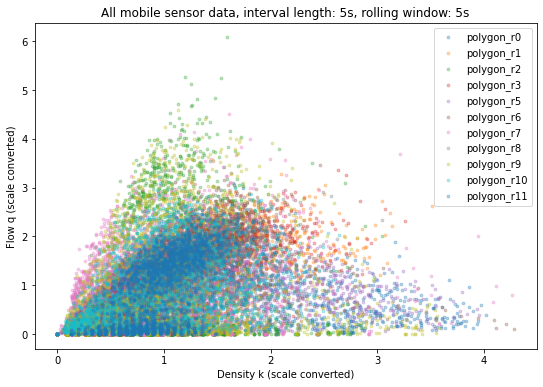

2160
2471
2496
2513
2330
2506
2396
2475
2491
2492
2515


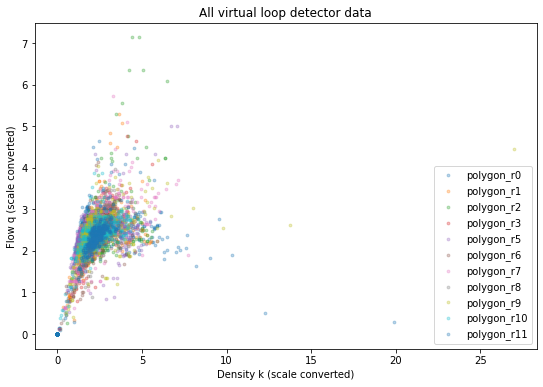

26845


In [5]:
data = all_data 

# allMS data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.q_all_MS,s=8,alpha=0.3,label=subset.polygon.values[0])
    print(len(subset.q_all_MS))

plt.title('All mobile sensor data, interval length: %s, rolling window: %s'%(resample,window))
plt.xlabel('Density k (scale converted)'); plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_MS_scaled.png')
plt.show()

# allLD data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_LD,subset.q_all_LD,s=8,alpha=0.3,label=subset.polygon.values[0])
    print(len(subset.q_all_LD))
plt.title('All virtual loop detector data')
plt.xlabel('Density k (scale converted)');plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_LD_scaled.png')
plt.show()
print(len(all_data))

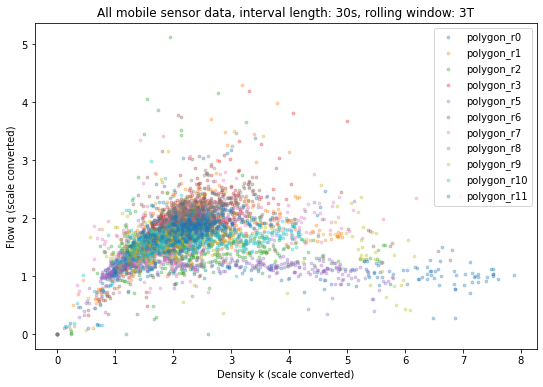

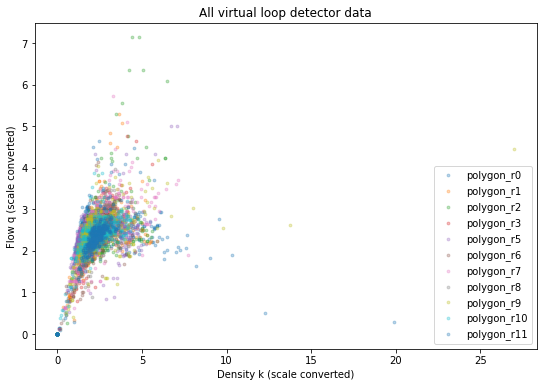

In [10]:
data = all_data 

# allMS data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.q_all_MS,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All mobile sensor data, interval length: %s, rolling window: %s'%(resample,window))
plt.xlabel('Density k (scale converted)'); plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_MS_scaled.png')
plt.show()

# allLD data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_LD,subset.q_all_LD,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All virtual loop detector data')
plt.xlabel('Density k (scale converted)');plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_LD_scaled.png')
plt.show()

#### Visualisation of the difference between v and vtarget

,polygon,vdiff,v_all,v2,q_all_LD,k_all_LD,q_all_LD_s,k_all_LD_s
0,polygon_r11,1.584690,10.414054,11.998744,0.292340,0.974767,414.780616,34.568670
1,polygon_r11,13.434926,25.913300,39.348226,2.046382,2.080699,2903.464312,73.788950
2,polygon_r11,11.295373,29.786912,41.082285,2.566098,2.499001,3640.852073,88.623407
3,polygon_r11,13.407224,26.592138,39.999362,1.973297,1.973727,2799.769158,69.995345
4,polygon_r11,12.855939,30.032306,42.888245,2.338722,2.181665,3318.244927,77.369566


Mean absolute speed difference: 7.21


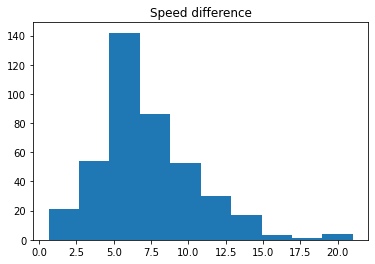

In [75]:
# test - scale values back up
cs = ['q_all_LD','k_all_LD']
result['q_all_LD'] = result.q_all
result['k_all_LD'] = result.k_all
for c in ['q_all_LD','k_all_LD']:
    scaledup = scaleup(result[c],result['polygon'],scalefactors,c)
    result['%s_s'%c] = scaledup
    cs.append('%s_s'%c)
result['v2'] = result.q_all_LD_s / result.k_all_LD_s

# difference between true 3min speed and derived 3min speed
result['vdiff'] = result.v2-result.v_all
display(result[['polygon','vdiff','v_all','v2']+cs].head())
print('Mean absolute speed difference: %.2f'%abs(result.vdiff).mean())
plt.hist(result.vdiff)
plt.title('Speed difference')
plt.show()

### Check for low speeds -> for bottlenecks

In [22]:
#Filter for slow in genereal
#ideas: speed-diff between bus and all (heavy, medium)
all_slow = all_data[all_data['v_all_MS']<20]
super_slow = all_data[all_data['v_all_MS']<10]
print('all_slow',len(all_slow),'super_slow',len(super_slow),'all_data',len(all_data))

all_slow 505 super_slow 261 all_data 4669


In [ ]:
#1 do speed diff for heavy, medium, taxi
#2 do single botlenecks for each
#3 do either/or bottleneck
#4 do 2 or more bottleneck
#5 give ranking (e.g. speed diff - 30, 20, 10)

In [27]:
bottlenecks = all_data.copy()
bottlenecks['speed_diff_all_bus'] = bottlenecks.v_all_MS - bottlenecks.v_Bus_MS
bottlenecks['speed_diff_all_medium'] = bottlenecks.v_all_MS - bottlenecks['v_Medium Vehicle_MS']
bottlenecks['speed_diff_all_heavy'] = bottlenecks.v_all_MS - bottlenecks['v_Heavy Vehicle_MS']
bottlenecks['speed_diff_all_taxi'] = bottlenecks.v_all_MS - bottlenecks.v_Taxi_MS
bottlenecks['speed_diff_car_bus'] = bottlenecks.v_Car_MS - bottlenecks.v_Bus_MS
bottlenecks['speed_diff_car_medium'] = bottlenecks.v_Car_MS - bottlenecks['v_Medium Vehicle_MS']
bottlenecks['speed_diff_car_heavy'] = bottlenecks.v_Car_MS - bottlenecks['v_Heavy Vehicle_MS']
bottlenecks['speed_diff_car_taxi'] = bottlenecks.v_Car_MS - bottlenecks.v_Taxi_MS
bottlenecks['bus_stop'] = (bottlenecks['speed_diff_car_bus'] > 15) & (bottlenecks['v_Bus_MS'] < 5)
bottlenecks['heavy_stop'] = (bottlenecks['speed_diff_car_heavy'] > 15) & (bottlenecks['v_Heavy Vehicle_MS'] < 5)
bottlenecks['medium_stop'] = (bottlenecks['speed_diff_car_medium'] > 15) & (bottlenecks['v_Medium Vehicle_MS'] < 5)
bottlenecks['taxi_stop'] = (bottlenecks['speed_diff_car_taxi'] > 15) & (bottlenecks['v_Taxi_MS'] < 5)
bottlenecks['any_vehicle_stop'] = (bottlenecks['bus_stop'] | bottlenecks['medium_stop'] | bottlenecks['heavy_stop'] | bottlenecks['taxi_stop'])
bottlenecks['stop_counts'] = (bottlenecks['bus_stop']/1+bottlenecks['medium_stop']/1+bottlenecks['heavy_stop']/1+bottlenecks['taxi_stop']/1)

bottlenecks.head(10)

,exp_id,polygon,DOW,times,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,v_Medium Vehicle_MS,k_Medium Vehicle_MS,q_Medium Vehicle_MS,...,speed_diff_car_bus,speed_diff_car_medium,speed_diff_car_heavy,speed_diff_car_taxi,bus_stop,heavy_stop,medium_stop,taxi_stop,any_vehicle_stop,stop_counts
0,1.0,polygon_r0,Wed,2018-10-24 08:31:35,45.449044,0.057659,0.084569,NaN,0.000000,0.000000,...,4.695734,NaN,NaN,1.728552,False,False,False,False,False,0.0
6,1.0,polygon_r0,Wed,2018-10-24 08:32:05,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,False,False,False,False,False,0.0
12,1.0,polygon_r0,Wed,2018-10-24 08:32:35,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,False,False,False,False,False,0.0
18,1.0,polygon_r0,Wed,2018-10-24 08:33:05,50.542265,0.102758,0.167607,NaN,0.000000,0.000000,...,NaN,NaN,14.736732,-5.009644,False,False,False,False,False,0.0
24,1.0,polygon_r0,Wed,2018-10-24 08:33:35,NaN,0.000000,0.000000,38.632065,0.085632,0.106759,...,NaN,NaN,NaN,NaN,False,False,False,False,False,0.0
30,1.0,polygon_r0,Wed,2018-10-24 08:34:05,42.482957,0.077068,0.105661,NaN,0.000000,0.000000,...,NaN,NaN,NaN,14.984549,False,False,False,False,False,0.0
36,1.0,polygon_r0,Wed,2018-10-24 08:34:35,47.377892,0.118253,0.180805,40.414631,0.082777,0.107962,...,-3.472243,9.453359,NaN,0.607252,False,False,False,False,False,0.0
42,1.0,polygon_r0,Wed,2018-10-24 08:35:05,NaN,0.000000,0.000000,40.453986,0.091340,0.119247,...,NaN,5.566195,NaN,NaN,False,False,False,False,False,0.0
48,1.0,polygon_r0,Wed,2018-10-24 08:35:35,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,-7.508634,False,False,False,False,False,0.0
54,1.0,polygon_r0,Wed,2018-10-24 08:36:05,NaN,0.000000,0.000000,51.469437,0.108467,0.180164,...,NaN,-0.684316,NaN,NaN,False,False,False,False,False,0.0


In [28]:
bottlenecks.stop_counts.value_counts()

0.0    25065
1.0     1496
2.0      262
3.0       21
4.0        1
Name: stop_counts, dtype: int64

In [74]:
min_2 = bottlenecks[bottlenecks.stop_counts>=1]

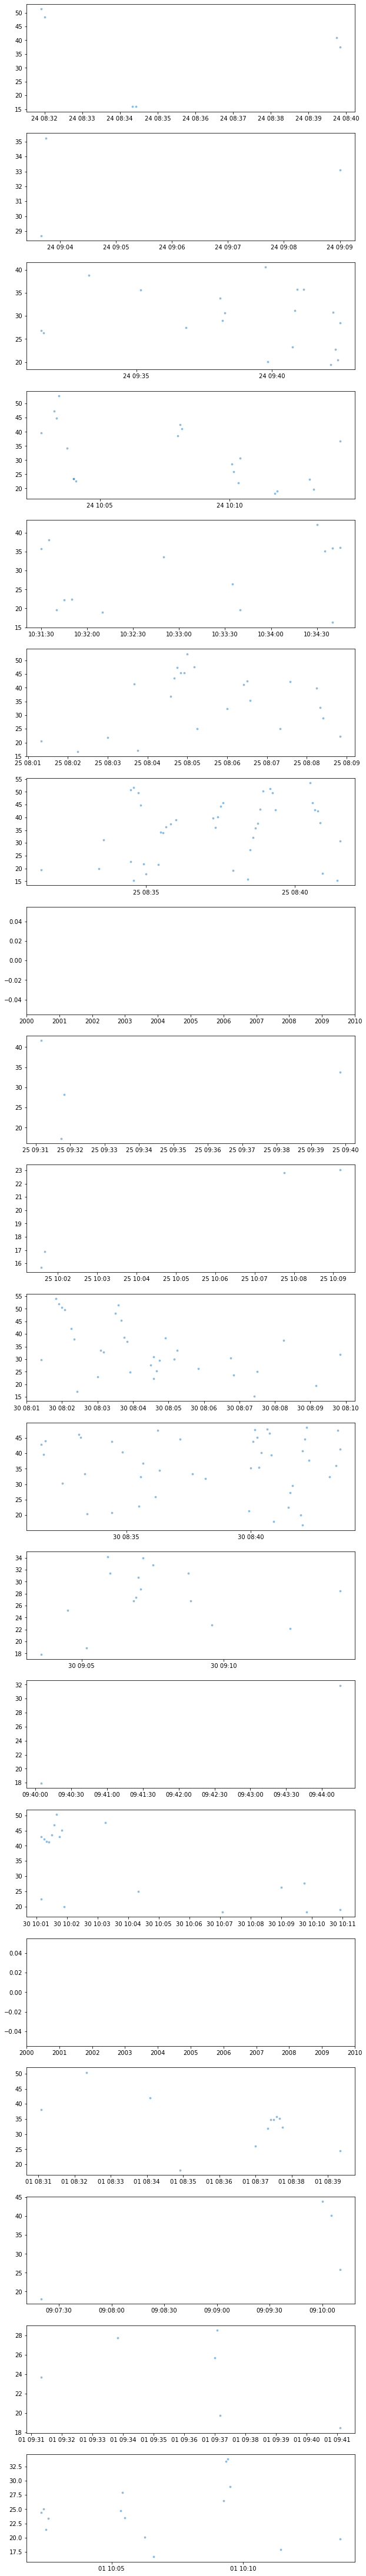

In [50]:
fig, axs = plt.subplots(20, figsize = (10,80))
for a in range(1,21):
    axs[a-1].scatter(min_2[min_2.exp_id==a].times, min_2[min_2.exp_id==a].v_Car_MS,s=8,alpha=0.4)
    axs[a-1].label=a

In [75]:
e4_min2 = min_2[min_2.exp_id==19]
e4_min2[['exp_id','polygon','times','v_Car_MS','q_Car_MS','v_Car0050_MS','speed_diff_car_bus',
         'speed_diff_car_medium', 'speed_diff_car_heavy', 'speed_diff_car_taxi','stop_counts']]

,exp_id,polygon,times,v_Car_MS,q_Car_MS,v_Car0050_MS,speed_diff_car_bus,speed_diff_car_medium,speed_diff_car_heavy,speed_diff_car_taxi,stop_counts
14400,19.0,polygon_r1,2018-11-01 09:37:00,17.174994,0.305485,45.741775,15.674186,NaN,NaN,1.915384,1.0
14406,19.0,polygon_r1,2018-11-01 09:37:30,28.434091,0.618974,35.748909,27.499781,NaN,NaN,2.114823,1.0
14460,19.0,polygon_r1,2018-11-01 09:42:00,21.645455,0.617724,28.836686,0.502607,21.645455,NaN,-6.873202,1.0
16713,19.0,polygon_r1,2018-11-01 09:31:20,23.685514,0.836284,NaN,18.717490,NaN,21.145972,4.498000,2.0
16769,19.0,polygon_r1,2018-11-01 09:36:55,20.118412,0.363180,NaN,15.538331,NaN,NaN,3.558814,1.0
...,...,...,...,...,...,...,...,...,...,...,...
89761,19.0,polygon_r11,2018-11-01 09:37:05,41.276189,0.585353,NaN,41.276189,-2.972082,NaN,12.655378,1.0
89762,19.0,polygon_r11,2018-11-01 09:37:10,23.856186,0.293983,NaN,23.856186,9.349863,NaN,2.294478,1.0
89791,19.0,polygon_r11,2018-11-01 09:40:05,33.921580,0.636982,NaN,33.661634,NaN,NaN,-5.654448,1.0
89792,19.0,polygon_r11,2018-11-01 09:40:10,25.409349,0.337973,NaN,25.409349,NaN,NaN,-8.537878,1.0


<AxesSubplot:>

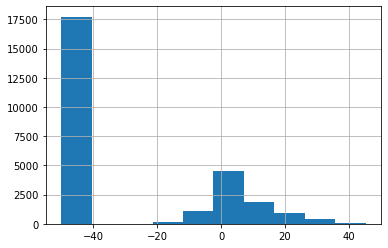

In [12]:
bottlenecks.speed_diff_car_bus.fillna(-50).hist()

In [7]:
only_with_bus = bottlenecks[~bottlenecks.speed_diff_car_bus.isnull()]

In [ ]:
only_with_bus.columns

<AxesSubplot:>

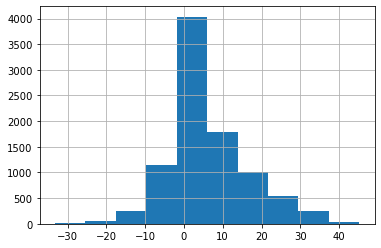

In [35]:
#current: Nan where no bus, difference between bus and car
#correlation should be: high car when high bus or low car and low bus (no influence), 
#lower car when diff positive high and bus 0 compared to no bus

#--> mean car for bus<10 and speed_diff > 20
#--> mean car for no bus

only_with_bus.speed_diff_car_bus.hist()

In [ ]:
only_with_bus.boxplot(by='speed_diff_car_bus')#.hist(bins=25)


KeyboardInterrupt



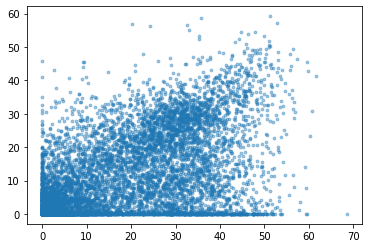

In [34]:
plt.scatter(only_with_bus.v_Car_MS,only_with_bus.v_Bus_MS,s=8,alpha=0.4)
#only_with_bus[only_with_bus.speed_diff_car_bus]

In [15]:
only_with_bus[['exp_id','v_all_MS','v_Bus_MS','v_Car_MS','speed_diff_car_bus','q_Car0050_MS','lanes', 'direction', 'busstops',
       'seplane', 'length', 'complexity']].corr('pearson')

,exp_id,v_all_MS,v_Bus_MS,v_Car_MS,speed_diff_car_bus,q_Car0050_MS,lanes,direction,busstops,seplane,length,complexity
exp_id,1.000000,0.087055,0.057387,0.082788,0.047071,0.022832,0.018333,0.010269,0.077194,-0.054983,0.035468,NaN
v_all_MS,0.087055,1.000000,0.684634,0.930807,0.510710,0.071677,0.327045,0.027615,0.008571,0.144894,0.069364,NaN
v_Bus_MS,0.057387,0.684634,1.000000,0.555598,-0.277014,0.043778,0.091144,0.123033,-0.239094,0.356459,-0.081848,NaN
v_Car_MS,0.082788,0.930807,0.555598,1.000000,0.563920,0.062741,0.384232,-0.028918,0.100312,0.042225,0.136049,NaN
speed_diff_car_bus,0.047071,0.510710,-0.277014,0.563920,1.000000,0.042851,0.323624,-0.108719,0.293321,-0.229449,0.187983,NaN
q_Car0050_MS,0.022832,0.071677,0.043778,0.062741,0.042851,1.000000,0.007488,-0.010892,0.004853,-0.015841,-0.007302,NaN
lanes,0.018333,0.327045,0.091144,0.384232,0.323624,0.007488,1.000000,-0.385975,0.190217,0.002271,0.584298,NaN
direction,0.010269,0.027615,0.123033,-0.028918,-0.108719,-0.010892,-0.385975,1.000000,0.193777,0.109805,-0.195322,NaN
busstops,0.077194,0.008571,-0.239094,0.100312,0.293321,0.004853,0.190217,0.193777,1.000000,-0.707518,0.117370,NaN
seplane,-0.054983,0.144894,0.356459,0.042225,-0.229449,-0.015841,0.002271,0.109805,-0.707518,1.000000,0.018844,NaN


In [28]:
pol0_all = all_data[all_data['polygon'] == 'polygon_r0']
len(pol0_all)

417

In [42]:
for row,index in pol0_all.iterrows():
    print(row, index['times'], index.v_all_MS)

0 2018-10-24 08:30:00 40.790122970952055
1 2018-10-24 08:33:00 42.80521216764917
2 2018-10-24 08:36:00 44.15276177141456
3 2018-10-24 08:39:00 47.93096732490546
10 2018-10-24 09:00:00 33.63439159420024
11 2018-10-24 09:03:00 7.6813235987032344
12 2018-10-24 09:06:00 9.716112636127058
13 2018-10-24 09:09:00 7.475230841988899
14 2018-10-24 09:12:00 7.255886096150206
20 2018-10-24 09:30:00 6.009259904518497
21 2018-10-24 09:33:00 6.1147065195841686
22 2018-10-24 09:36:00 8.163732840105569
23 2018-10-24 09:39:00 5.281993229116394
24 2018-10-24 09:42:00 5.804997263690013
30 2018-10-24 10:00:00 4.659420785084534
31 2018-10-24 10:03:00 5.983137734383291
32 2018-10-24 10:06:00 6.59463631783115
33 2018-10-24 10:09:00 7.393292003741533
34 2018-10-24 10:12:00 7.164103465518976
40 2018-10-24 10:30:00 8.294393857891855
41 2018-10-24 10:33:00 6.03004425186396
42 2018-10-24 10:36:00 1.0660330301681655
43 2018-10-25 08:00:00 47.59109039577289
44 2018-10-25 08:03:00 44.599719384997236
45 2018-10-25 08:

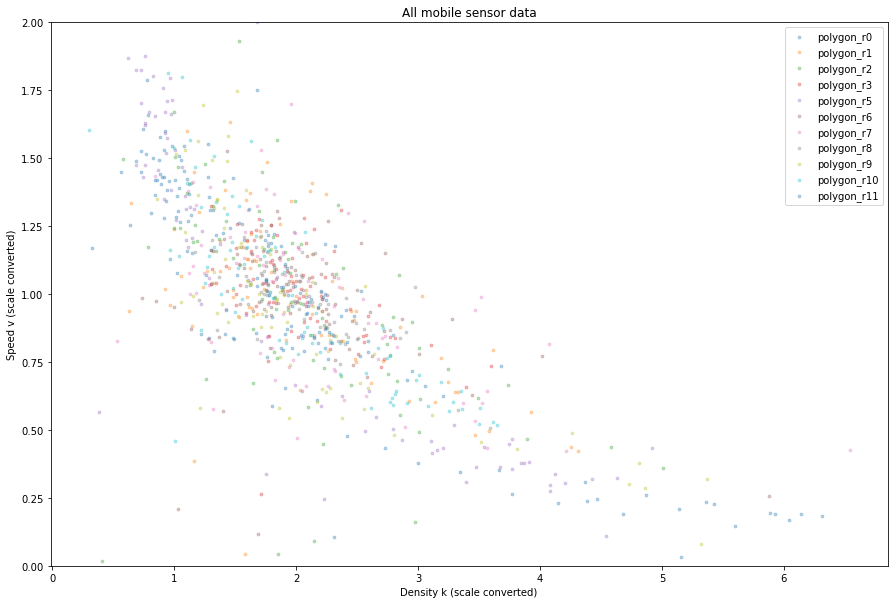

In [23]:
# allMS data - speed-density plot - scaled by mean-speed and density
plt.figure(figsize=(15,10))
speed_scales = all_data.groupby(['polygon'])['v_all_MS'].mean()
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    speed_scale = speed_scales['polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.v_all_MS/speed_scale,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All mobile sensor data')
plt.xlabel('Density k (scale converted)'); plt.ylabel('Speed v (scale converted)'); plt.legend()
plt.ylim(0,2)
#plt.savefig('All_MS_scaled.png')
plt.show()

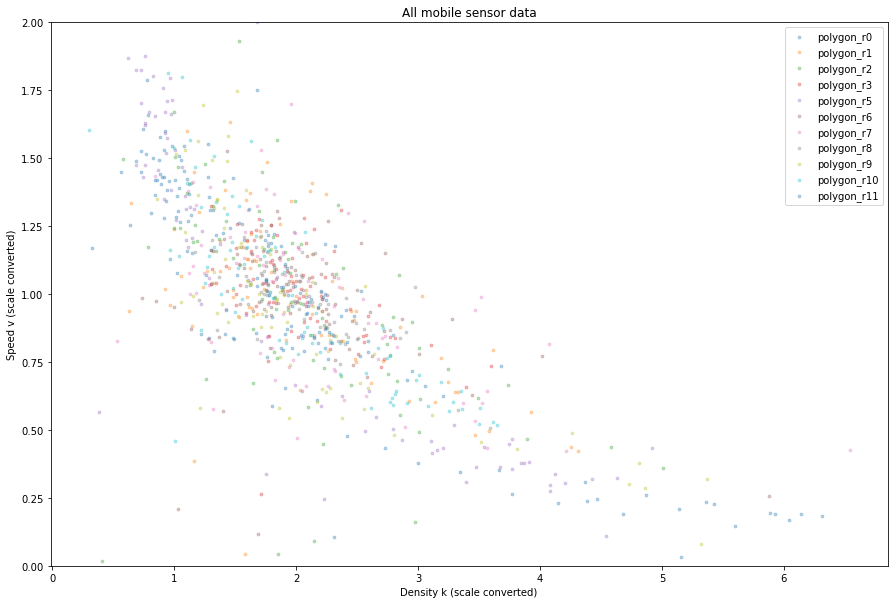

In [24]:
# allMS data - speed-density plot - scaled by mean-speed and density
plt.figure(figsize=(15,10))
speed_scales = all_data.groupby(['polygon'])['v_all_MS'].mean()
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    speed_scale = speed_scales['polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.v_all_MS/speed_scale,s=8,alpha=0.3,label=subset.polygon.values[0])
plt.title('All mobile sensor data')
plt.xlabel('Density k (scale converted)'); plt.ylabel('Speed v (scale converted)'); plt.legend()
plt.ylim(0,2)
#plt.savefig('All_MS_scaled.png')
plt.show()

In [25]:
to_check = super_slow.value_counts(['polygon','exp_id'])
to_check

polygon      exp_id
polygon_r10  18.0      5
polygon_r9   3.0       5
polygon_r0   3.0       5
polygon_r2   20.0      5
polygon_r7   4.0       5
                      ..
polygon_r2   13.0      1
             11.0      1
polygon_r7   7.0       1
             11.0      1
polygon_r3   1.0       1
Length: 86, dtype: int64

In [26]:
to_check.loc[['polygon_r0','polygon_r5','polygon_r9'],:]

polygon     exp_id
polygon_r0  3.0       5
            4.0       5
            2.0       4
            5.0       3
            15.0      1
polygon_r5  3.0       5
            2.0       5
            4.0       4
            15.0      4
            5.0       3
            10.0      2
            20.0      2
polygon_r9  3.0       5
            2.0       5
            17.0      5
            14.0      4
            1.0       4
            13.0      4
            18.0      3
            9.0       3
            10.0      3
            15.0      3
            4.0       3
            20.0      3
            5.0       2
            12.0      2
            19.0      1
            11.0      1
            6.0       1
dtype: int64

In [11]:
#super_slow_exp2_r0 = super_slow[(super_slow.exp_id == 1.0) & (super_slow.polygon == 'polygon_r0')]
exp2_r = all_data[(all_data.exp_id == 6.0) & (all_data.polygon == 'polygon_r9')]
exp2_r[['times','v_all_MS']]

,times,v_all_MS
11876,2018-10-25 08:01:00,18.906831
11877,2018-10-25 08:01:30,13.558602
11878,2018-10-25 08:02:00,9.602749
11879,2018-10-25 08:02:30,13.006471
11880,2018-10-25 08:03:00,12.987725
11881,2018-10-25 08:03:30,11.134856
11882,2018-10-25 08:04:00,11.015376
11883,2018-10-25 08:04:30,11.242612
11884,2018-10-25 08:05:00,11.176129
11885,2018-10-25 08:05:30,10.085056


In [77]:
all_data.columns

Index(['exp_id', 'polygon', 'DOW', 'times', 'v_Taxi_MS', 'k_Taxi_MS',
       'q_Taxi_MS', 'v_Car0050_MS', 'k_Car0050_MS', 'q_Car0050_MS', 'v_Car_MS',
       'k_Car_MS', 'q_Car_MS', 'v_Heavy Vehicle_MS', 'k_Heavy Vehicle_MS',
       'q_Heavy Vehicle_MS', 'v_all_MS', 'k_all_MS', 'q_all_MS',
       'v_Medium Vehicle_MS', 'k_Medium Vehicle_MS', 'q_Medium Vehicle_MS',
       'v_Bus_MS', 'k_Bus_MS', 'q_Bus_MS', 'v_Motorcycle_MS',
       'k_Motorcycle_MS', 'q_Motorcycle_MS', 'lanes', 'direction', 'busstops',
       'seplane', 'length', 'complexity', 'road_rank', 'v_all_LD', 'k_all_LD',
       'q_all_LD'],
      dtype='object')

In [13]:
extended_data = all_data.copy()

In [14]:
extended_data['diff_car_bus'] = extended_data['v_Car_MS'] - extended_data['v_Bus_MS']
extended_data['diff_car_heavy'] = extended_data['v_Car_MS'] - extended_data['v_Heavy Vehicle_MS']
extended_data['diff_car_taxi'] = extended_data['v_Car_MS'] - extended_data['v_Taxi_MS']

<AxesSubplot:>

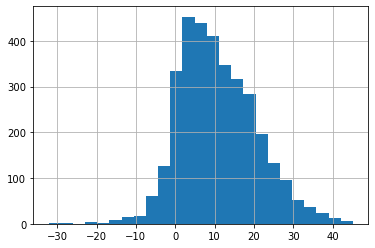

In [21]:
extended_data['diff_car_bus'].hist(bins=25)

<AxesSubplot:>

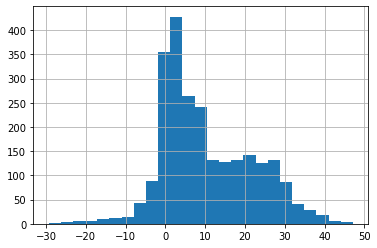

In [22]:
extended_data['diff_car_heavy'].hist(bins=25)

<AxesSubplot:>

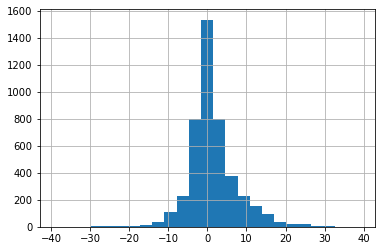

In [23]:
extended_data['diff_car_taxi'].hist(bins=25)

<AxesSubplot:>

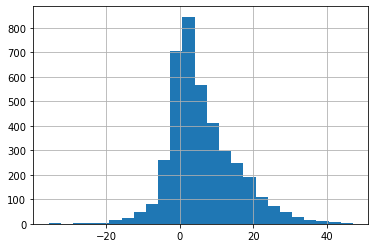

In [24]:
extended_data['diff_car_medium'] = extended_data['v_Car_MS'] - extended_data['v_Medium Vehicle_MS']
extended_data['diff_car_medium'].hist(bins=25)

<AxesSubplot:>

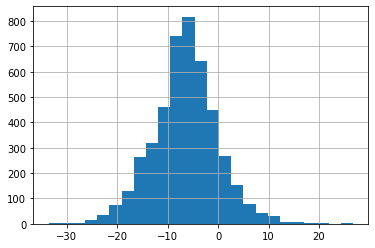

In [25]:
extended_data['diff_car_motorcycle'] = extended_data['v_Car_MS'] - extended_data['v_Motorcycle_MS']
extended_data['diff_car_motorcycle'].hist(bins=25)

<AxesSubplot:>

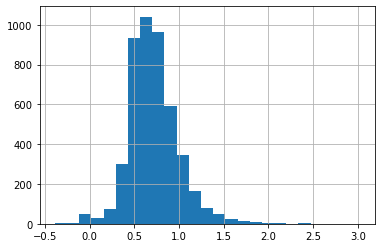

In [26]:
extended_data['diff_qcar_bus'] = extended_data['q_Car_MS'] - extended_data['q_Bus_MS']
extended_data['diff_qcar_heavy'] = extended_data['q_Car_MS'] - extended_data['q_Heavy Vehicle_MS']
extended_data['diff_qcar_mocy'] = extended_data['q_Car_MS'] - extended_data['q_Motorcycle_MS']
extended_data['diff_qcar_bus'].hist(bins=25)

<AxesSubplot:>

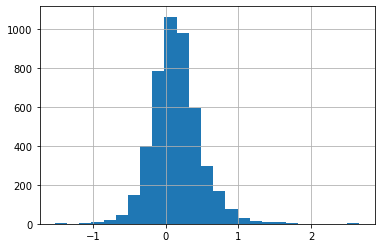

In [29]:
#extended_data['diff_qcar_heavy'].hist(bins=25)
extended_data['diff_qcar_mocy'].hist(bins=25)

In [66]:
all_data.times.info

<bound method Series.info of 0       2018-10-24 08:31:00
1       2018-10-24 08:31:30
2       2018-10-24 08:32:00
3       2018-10-24 08:32:30
4       2018-10-24 08:33:00
                ...        
14381   2018-10-30 09:45:00
14382   2018-10-30 09:45:30
14383   2018-10-30 09:46:00
14384   2018-10-30 09:46:30
14385   2018-10-30 09:47:00
Name: times, Length: 4668, dtype: datetime64[ns]>

In [85]:
import datetime
times = []
values = []
for ti in range(0,30):
    times.append(datetime.datetime(2022,6,13,10,14,ti))
    values.append(ti**2) 

In [86]:
rand_df = pd.DataFrame(list(zip(times,values)), columns = ['Zeitstempel','Werte'])
rand_df.index = pd.Series(times)

In [87]:
rand_df_res = rand_df.resample('8s').mean()

In [88]:
rand_df_res

,Werte
2022-06-13 10:14:00,17.500000
2022-06-13 10:14:08,137.500000
2022-06-13 10:14:16,385.500000
2022-06-13 10:14:24,705.166667
